# EvoGFuzz: An Evolutionary Approach to Grammar-Based Fuzzing

**EvoGFuzz** stands for *evolutionary grammar-based fuzzing*. This approach leverages evolutionary optimization techniques to systematically explore the space of a program's potential inputs, with a particular emphasis on identifying inputs that could lead to exceptional behavior. With a user-defined objective, EvoGFuzz can adapt and refine the input generation strategy over time, making it a powerful tool for uncovering software defects and vulnerabilities.

Efficient detection of defects and vulnerabilities hinges on the ability to automatically generate program inputs that are both valid and diverse. One common strategy is to use grammars, which provide structured and syntactically correct inputs. This approach leads to the concept of grammar-based fuzzing, where fuzzing strategies are guided by the rules defined within the grammar.

A further enhancement to this concept is probabilistic grammar-based fuzzing, where competing grammar rules are associated with probabilities that guide their application. By carefully assigning and optimizing these probabilities, we gain considerable control over the nature of the generated inputs. This enables us to direct the fuzzing process towards specific areas of interest—for example, those functions that are deemed critical, have a higher propensity for failures, or have undergone recent modifications. 

In essence, EvoGFuzz represents a potent blend of evolutionary optimization and probabilistic grammar-based fuzzing, poised to reveal hidden defects and vulnerabilities in a targeted and efficient manner.

## Fuzzing a Program

Our program under investigation is `The Calculator`. This program acts as a typical calculator, capable of evaluating not just arithmetic expressions but also trigonometric functions, such as sine, cosine, and tangent. Furthermore, it also supports the calculation of the square root of a given number.

In [1]:
import math

def calculator(inp: str) -> float:
    """
        A simple calculator function that can evaluate arithmetic expressions 
        and perform basic trigonometric functions and square root calculations.
    """
    return eval(
        str(inp), {"sqrt": math.sqrt, "sin": math.sin, "cos": math.cos, "tan": math.tan}
    )

**Side Note:** In the `calculator`, we use Python's `eval` function, which takes a string and evaluates it as a Python expression. We provide a dictionary as the second argument to eval, mapping names to corresponding mathematical functions. This enables us to use the function names directly within the input string. 

In [2]:
# Evaluating the cosine of 2π
print(calculator('cos(6*3.141)'))

0.999993677717667


In [3]:
# Calculating the square root of 36
print(calculator('sqrt(6*6)'))

6.0


Each of these calls to the calculator will evaluate the provided string as a mathematical expression, and print the result.

Now, to find new defects, we need to introduce an oracle that tells us if the error that is triggered is something we expect or a new/unkonwn defect. The `OracleResult` is an enum with two possible values, `NO_BUG` and `BUG`. `NO_BUG` donates a passing test case and `BUG` a failing one.

We import the `OracleResult` enumerated type from the `evogfuzz` library. This is used in the oracle function to indicate the outcome of executing the 'calculator' function with a given input.

In [4]:
from debugging_framework.input.oracle import OracleResult

This is a function called **oracle**, which acts as an intermediary to handle and classify exceptions produced by the calculator function when given a certain input.

In [5]:
# Make sure you use the OracleResult from the debugging_framework library
from debugging_framework.input.oracle import OracleResult

def oracle(inp: str):
    """
    This function serves as an oracle or intermediary that catches and handles exceptions 
    generated by the 'calculator' function. The oracle function is used in the context of fuzz testing.
    It aims to determine whether an input triggers a bug in the 'calculator' function.

    Args:
        inp (str): The input string to be passed to the 'calculator' function.

    Returns:
        OracleResult: An enumerated type 'OracleResult' indicating the outcome of the function execution.
            - OracleResult.PASSING: Returned if the calculator function executes without any exception or only with CalculatorSyntaxError
            - OracleResult.FAILING: Returned if the calculator function raises a ValueError exception, indicating a potential bug.
    """
    try:
        calculator(inp)
    except ValueError as e:
        return OracleResult.FAILING
    
    return OracleResult.PASSING

This **oracle** function is used in the context of fuzzing to determine the impact of various inputs on the program under test (in our case the _calculator_). When the calculator function behaves as expected (i.e., no exceptions occur), the **oracle** function returns `OracleResult.NO_BUG`. However, when the `calculator` function raises an unexpected exception, the **oracle** interprets this as a potential bug in the `calculator` and returns `OracleResult.BUG`.

We can see this in action by testing a few initial inputs:

In [6]:
initial_inputs = ['sqrt(1)', 'cos(912)', 'tan(4)']

for inp in initial_inputs:
    print(inp.ljust(20), oracle(inp))

sqrt(1)              PASSING
cos(912)             PASSING
tan(4)               PASSING


The following code represents a simple context-free grammar for our calculator function. This grammar encompasses all the potential valid inputs to the calculator, which include mathematical expressions involving square roots, trigonometric functions, and integer and decimal numbers:

In [7]:
from debugging_framework.types import Grammar
from debugging_framework.fuzzingbook.grammar import is_valid_grammar

CALCGRAMMAR: Grammar = {
    "<start>":
        ["<function>(<term>)"],

    "<function>":
        ["sqrt", "tan", "cos", "sin"],
    
    "<term>": ["-<value>", "<value>"], 
    
    "<value>":
        ["<integer>.<integer>",
         "<integer>"],

    "<integer>":
        ["<digit><integer>", "<digit>"],

    "<digit>":
        ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
}
    
assert is_valid_grammar(CALCGRAMMAR)

The defined grammar CALCGRAMMAR provides a structured blueprint for creating various inputs for our fuzz testing. Each rule in this grammar reflects a possible valid input that our calculator function can handle. By fuzzing based on this grammar, we can systematically explore the space of valid inputs to the calculator function.

### Leveraging EvoGFuzz to Unearth New Defects

We apply our `EvoGFuzz` class to carry out fuzz testing using evolutionary grammar-based fuzzing. This is aimed at uncovering potential defects in our 'calculator' function.

To initialize our EvoGFuzz instance, we require a grammar (in our case, `CALCGRAMMAR`), an oracle function, an initial set of inputs, a fitness function, and the number of iterations to be performed in the fuzzing process.

Upon creating the `EvoGFuzz` instance, we can execute the fuzzing process. The `fuzz()` method runs the fuzzing iterations, evolving the inputs based on our fitness function, and returns a collection of inputs that lead to exceptions in the 'calculator' function.

In [8]:
from evogfuzz.evogfuzz_class import EvoGFuzz

epp = EvoGFuzz(
    grammar=CALCGRAMMAR,
    oracle=oracle,
    inputs=initial_inputs,
    iterations=10
)

Upon creating the `EvoGFuzz` instance, we can execute the fuzzing process. The `.fuzz()` method runs the fuzzing iterations, evolving the inputs based on our fitness function, and returns a collection of inputs that lead to exceptions in the 'calculator' function.

In [9]:
found_exception_inputs = epp.fuzz()
print(f"EvoGFuzz found {len(found_exception_inputs)} bug-triggering inputs!")

EvoGFuzz found 320 bug-triggering inputs!


Lastly, we can examine the inputs that resulted in exceptions. This output can provide valuable insight into potential weaknesses in the 'calculator' function that need to be addressed.

In [10]:
# print only the first 20 bug-triggering inputs
for inp in list(found_exception_inputs)[:20]:
    print(str(inp))

sqrt(-2441)
sqrt(-638)
sqrt(-78454)
sqrt(-47123)
sqrt(-3)
sqrt(-368777233364818873831651242)
sqrt(-1111)
sqrt(-5121)
sqrt(-1134872875677772236468)
sqrt(-65)
sqrt(-617268558434736552427867824627127)
sqrt(-7622311)
sqrt(-6743787388671428652)
sqrt(-515)
sqrt(-28323519173861575851487461638)
sqrt(-2898)
sqrt(-999)
sqrt(-7942291445)
sqrt(-25568895511)
sqrt(-277)


This process illustrates the power of evolutionary grammar-based fuzzing in identifying new defects within our system. By applying evolutionary algorithms to our fuzzing strategy, we can guide the search towards more defect-prone regions of the input space.

Print number of bug-triggering inputs for each iteration (cumulative):

In [11]:
print(epp.get_benchmark())

[(1, 0), (2, 0), (3, 19), (4, 42), (5, 105), (6, 181), (7, 273), (8, 309), (9, 317), (10, 320)]


#### Analyzing and Sorting All Generated Inputs by Fitness

After the fuzzing process, you may want to examine all the generated inputs. These can be accessed using the `get_all_inputs()` method. Additionally, we can sort these inputs based on their fitness scores to gain insights into which inputs performed best according to our fitness function.

In [12]:
all_generated_inputs = epp.get_all_inputs()
all_generated_inputs_sorted = sorted(all_generated_inputs, key=lambda inp: inp.fitness, reverse=True)

Now, let's print out these sorted inputs along with their respective fitness scores. Inputs with higher fitness scores will be displayed first, as these are the ones our evolutionary process deemed more likely to uncover potential defects.

In [13]:
# investigate only the first 20 bug-triggering inputs
for inp in all_generated_inputs_sorted[:20]:
    print(f"{str(inp).ljust(40)} fitness: {inp.fitness}")

sqrt(-2441)                              fitness: 1
sqrt(-638)                               fitness: 1
sqrt(-78454)                             fitness: 1
sqrt(-3)                                 fitness: 1
sqrt(-47123)                             fitness: 1
sqrt(-368777233364818873831651242)       fitness: 1
sqrt(-1111)                              fitness: 1
sqrt(-5121)                              fitness: 1
sqrt(-1134872875677772236468)            fitness: 1
sqrt(-65)                                fitness: 1
sqrt(-617268558434736552427867824627127) fitness: 1
sqrt(-7622311)                           fitness: 1
sqrt(-6743787388671428652)               fitness: 1
sqrt(-515)                               fitness: 1
sqrt(-28323519173861575851487461638)     fitness: 1
sqrt(-2898)                              fitness: 1
sqrt(-999)                               fitness: 1
sqrt(-7942291445)                        fitness: 1
sqrt(-25568895511)                       fitness: 1
sqrt(-277)  

This output provides an overview of the evolved inputs and their effectiveness in revealing potential defects, as gauged by our fitness function. It is a valuable resource for understanding the behavior of our program under various inputs and the effectiveness of our evolutionary grammar-based fuzzing approach.

### Incorporating Custom Fitness Functions

The fitness function plays a crucial role in guiding the evolution process of our fuzzing inputs. A well-crafted fitness function can effectively direct the search towards the most promising regions of the input space.

To create your own fitness function, define a function that takes an `Input` instance and returns a float value. The return value represents the 'fitness' of the given input, with higher values indicating better fitness. Here is a simple template:

```python
from evogfuzz.input import Input

def fitness_function_XYZ(inp: Input) -> float:
    # Implement your fitness function here.
    return 0.0
```

For instance, suppose we're interested in inputs that invoke the cosine function in our calculator. We could define a fitness function `fitness_function_cos` that assigns a high fitness value to inputs containing 'cos'. (**Note that this might not be the best fitness function to find new expcetions.**)

In [14]:
from evogfuzz.input import Input

def fitness_function_cos(inp: Input) -> float:
    if 'cos' in str(inp):
        return 1.0
    else:
        return 0.0

Once your fitness function is defined, you can incorporate it into the `EvoGFuzz` instance by passing it as the `fitness_function` argument. 

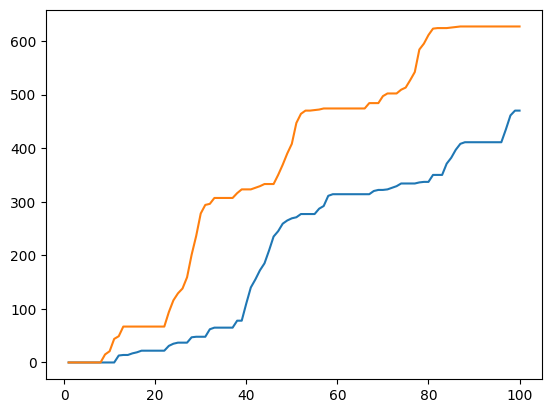

Area under Tournament: 20655.0
Area under Rank: 35811.5


In [15]:
from evogfuzz.evogfuzz_class import Strategy
import matplotlib.pyplot as plt
from numpy import trapz
epp = EvoGFuzz(
    grammar=CALCGRAMMAR,
    oracle=oracle,
    inputs=initial_inputs,
    fitness_function=fitness_function_cos,
    iterations=100,
    strategy=Strategy.TOURNAMENT
)

found_exception_inputs = epp.fuzz()
test_tournament = epp.get_benchmark()

epp = EvoGFuzz(
    grammar=CALCGRAMMAR,
    oracle=oracle,
    inputs=initial_inputs,
    fitness_function=fitness_function_cos,
    iterations=100,
    strategy=Strategy.RANK
)

found_exception_inputs = epp.fuzz()
test_rank = epp.get_benchmark()
xt = [a[0] for a in test_tournament]
yt = [a[1] for a in test_tournament]
plt.plot(xt, yt)
xr = [a[0] for a in test_rank]
yr = [a[1] for a in test_rank]
plt.plot(xr, yr)
plt.show()
area_t = trapz(yt, dx=1)
area_r = trapz(yr, dx=1)
print(f"Area under Tournament: {area_t}")
print(f"Area under Rank: {area_r}")

In [15]:
epp = EvoGFuzz(
    grammar=CALCGRAMMAR,
    oracle=oracle,
    inputs=initial_inputs,
    fitness_function=fitness_function_cos,
    iterations=100
)

found_exception_inputs = epp.fuzz()

print(f"EvoGFuzz found {len(found_exception_inputs)} bug-triggering inputs!")

for inp in found_exception_inputs:
    print(str(inp))

EvoGFuzz found 216 bug-triggering inputs!
sqrt(-9.4)
sqrt(-1.4)
sqrt(-87.8)
sqrt(-45341)
sqrt(-634.6)
sqrt(-3.35)
sqrt(-7656)
sqrt(-33.8)
sqrt(-9.3)
sqrt(-5.855)
sqrt(-227685628.71)
sqrt(-215572.5733525848463182)
sqrt(-5.1)
sqrt(-658.671116)
sqrt(-18.3)
sqrt(-3155617874.87469452632457)
sqrt(-64721157477717258852666916)
sqrt(-15.5114268)
sqrt(-5.6)
sqrt(-6918677.51761418488255455)
sqrt(-7.5)
sqrt(-5.4)
sqrt(-18.88431)
sqrt(-3727)
sqrt(-4.884654748316186)
sqrt(-74.81)
sqrt(-6.5)
sqrt(-9.9)
sqrt(-6.2)
sqrt(-4.3)
sqrt(-1.6)
sqrt(-8.5995)
sqrt(-4.7)
sqrt(-979.38)
sqrt(-5536.826)
sqrt(-5)
sqrt(-3.6)
sqrt(-451544.78458)
sqrt(-77.143)
sqrt(-78762.5)
sqrt(-9.7661147761)
sqrt(-47746847411467264)
sqrt(-72216157178531)
sqrt(-8.7)
sqrt(-3.79)
sqrt(-71253.3)
sqrt(-8.437)
sqrt(-553.3)
sqrt(-18.7)
sqrt(-98)
sqrt(-3.9)
sqrt(-311)
sqrt(-876.7)
sqrt(-15.5)
sqrt(-7462671769.6)
sqrt(-443648831388.729)
sqrt(-451479954394755.17675371)
sqrt(-13.4)
sqrt(-4.8)
sqrt(-7.86)
sqrt(-71514248.6856)
sqrt(-38.58)
sqrt(

This way, the evolutionary grammar-based fuzzing process is now guided by your custom fitness function, focusing more on the areas you deem critical.

#### Evaluating Inputs Based on Custom Fitness Function

When utilizing a custom fitness function, such as `fitness_function_cos` in our case, we expect inputs containing 'cos' to achieve the highest fitness scores. This is because our fitness function assigns a score of 1.0 to any input that includes 'cos'.

To confirm this behavior, we retrieve all inputs generated during the fuzzing process using the `get_all_inputs()` method and sort these inputs based on their fitness scores.

In [16]:
all_generated_inputs = epp.get_all_inputs()
all_generated_inputs_sorted = sorted(all_generated_inputs, key=lambda inp: inp.fitness, reverse=True)

Let's display these sorted inputs along with their fitness scores. The inputs that contain 'cos' should appear first, demonstrating their high fitness value.

In [17]:
# investigate only the first 20 bug-triggering inputs
for inp in all_generated_inputs_sorted[:20]:
    print(f"{str(inp).ljust(40)} fitness: {inp.fitness}")

cos(82)                                  fitness: 1.0
cos(-53.3377)                            fitness: 1.0
cos(-5.9)                                fitness: 1.0
cos(1.7)                                 fitness: 1.0
cos(92299994.9)                          fitness: 1.0
cos(25.47)                               fitness: 1.0
cos(3277271.2729)                        fitness: 1.0
cos(2.6)                                 fitness: 1.0
cos(-7.23)                               fitness: 1.0
cos(43461.232)                           fitness: 1.0
cos(3274.2)                              fitness: 1.0
cos(93343353493747433614.7)              fitness: 1.0
cos(-397)                                fitness: 1.0
cos(2.24)                                fitness: 1.0
cos(2.9299292)                           fitness: 1.0
cos(99.942922422922)                     fitness: 1.0
cos(1912)                                fitness: 1.0
cos(779327773.262)                       fitness: 1.0
cos(3447.36762234149)       

The resulting output validates the effectiveness of our custom fitness function. It shows how we can guide the evolutionary grammar-based fuzzing process towards specific regions of the input space, thereby facilitating targeted exploration and bug discovery.

In [18]:
test = epp.get_benchmark()
print(test)

[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 12), (32, 15), (33, 15), (34, 35), (35, 57), (36, 80), (37, 94), (38, 100), (39, 108), (40, 114), (41, 114), (42, 114), (43, 114), (44, 114), (45, 114), (46, 114), (47, 114), (48, 114), (49, 114), (50, 116), (51, 116), (52, 116), (53, 116), (54, 116), (55, 116), (56, 116), (57, 136), (58, 138), (59, 138), (60, 138), (61, 138), (62, 138), (63, 138), (64, 151), (65, 164), (66, 168), (67, 168), (68, 168), (69, 171), (70, 171), (71, 171), (72, 171), (73, 171), (74, 171), (75, 171), (76, 183), (77, 185), (78, 185), (79, 194), (80, 205), (81, 207), (82, 210), (83, 212), (84, 212), (85, 212), (86, 212), (87, 212), (88, 212), (89, 212), (90, 212), (91, 212), (92, 212), (93, 212), (94, 212), (95, 212), (96, 216), (97, 216), (98, 216

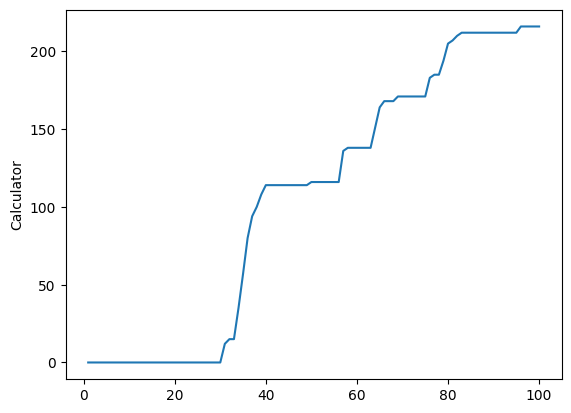

In [19]:
import matplotlib.pyplot as plt

x = [a[0] for a in test]
y = [a[1] for a in test]
plt.plot(x, y)
plt.ylabel("Calculator")
plt.show()

In [20]:
from typing import List

from debugging_framework.benchmark.program import BenchmarkProgram

from debugging_benchmark.calculator.calculator import CalculatorBenchmarkRepository
from debugging_benchmark.middle.middle import MiddleBenchmarkRepository
from debugging_benchmark.expression.expression import ExpressionBenchmarkRepository
from debugging_benchmark.markup.markup import MarkupBenchmarkRepository

repo_subjects: List[BenchmarkProgram] = MiddleBenchmarkRepository().build()
subject: BenchmarkProgram = repo_subjects[0]
oracle = subject.get_oracle()
grammar = subject.get_grammar()

from typing import List
from debugging_framework.benchmark.repository import BenchmarkRepository

repos: List[BenchmarkRepository] = [
    CalculatorBenchmarkRepository(),
    MiddleBenchmarkRepository(),
    ExpressionBenchmarkRepository(),
    MarkupBenchmarkRepository(),
]

from debugging_framework.benchmark.program import BenchmarkProgram

subjects: List[BenchmarkProgram] = []
for repo in repos:
    for prog in repo.build():
        subjects.append(prog)

subject = subjects[0]

epp = EvoGFuzz(
    grammar=subject.get_grammar(),
    oracle=subject.get_oracle(),
    inputs=subject.get_passing_inputs(),
    iterations=100
)
found_exception_inputs = epp.fuzz()
test = epp.get_benchmark()

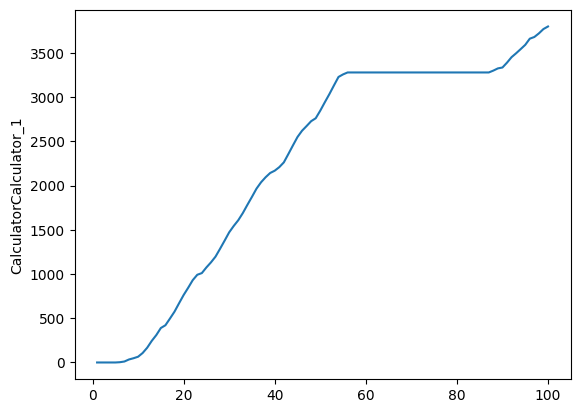

224737.0


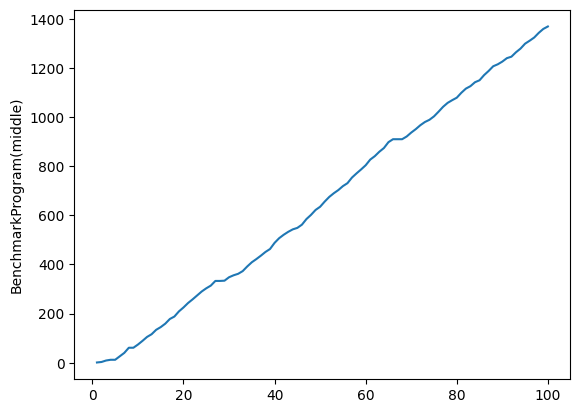

65014.0


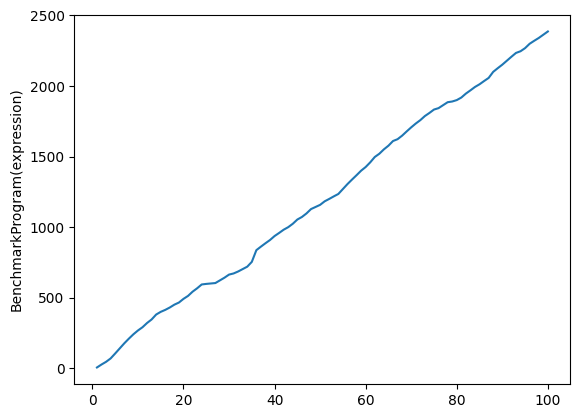

118884.0


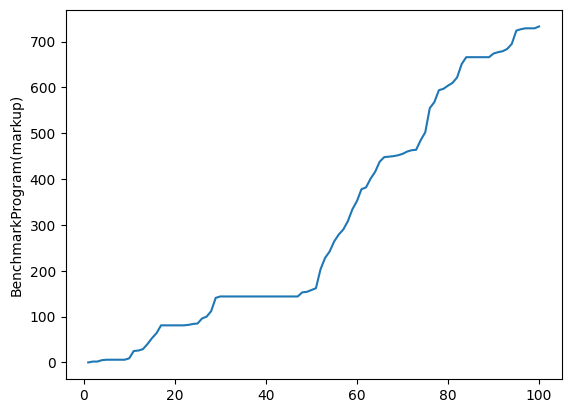

30043.5


In [21]:
from numpy import trapz
for s in subjects:
    epp = EvoGFuzz(
    grammar=s.get_grammar(),
    oracle=s.get_oracle(),
    inputs=s.get_passing_inputs(),
    iterations=100
    )
    found_exception_inputs = epp.fuzz()
    test = epp.get_benchmark()

    x = [a[0] for a in test]
    y = [a[1] for a in test]
    plt.plot(x, y)
    plt.ylabel(s)
    plt.show()
    area = trapz(y, dx=1)
    print(area)
    
    